In [1]:
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np

In [2]:
class BestEpochCallback(Callback):
    def __init__(self):
        super(BestEpochCallback, self).__init__()
        self.best_epoch = 0
        self.best_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("val_loss")
        if current_loss < self.best_loss:
            self.best_epoch = epoch
            self.best_loss = current_loss


class TestBench:
    def __init__(self, batch_size=128, epochs=32, dropout=0, augmentation=None, kernel_scale = 1, filter_scale =1):

        # Split the training data into training and validation sets
        # Load CIFAR-10 dataset splits
        (x_train, y_train), (self.x_test, self.y_test) = load_data()

        # Convert class vectors to one-hot encoding
        y_train = to_categorical(y_train, 10)
        self.y_test = to_categorical(self.y_test, 10)

        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)  

        model = models.Sequential()
        model.add(layers.Conv2D(filters=6*filter_scale, kernel_size=(5*kernel_scale, 5*kernel_scale), activation='relu', input_shape=(32, 32, 3)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        model.add(layers.Conv2D(filters=16*filter_scale, kernel_size=(5*kernel_scale, 5*kernel_scale), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=120, activation='relu'))

        model.add(layers.Dense(units=84, activation='relu'))
        model.add(layers.Dense(units=10, activation='softmax'))
        # Compile the model with categorical cross-entropy loss and Adam optimizer
        model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy", Precision(), Recall()],
        )
        model.build()
        model.summary()

        # Define a callback to save the best model based on validation loss
        best_epoch_callback = BestEpochCallback()
        checkpoint_callback = ModelCheckpoint(
            "best_model.h5",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            save_weights_only=False,
            verbose=1,
            save_freq="epoch",
            save_best_at_end=True,
        )
        callbacks = [checkpoint_callback, best_epoch_callback]

        if augmentation != None:
            # augmentation call
            augmentation.fit(x_train)
            self.history = model.fit(
                augmentation.flow(x_train, y_train, batch_size=batch_size) if augmentation is not None else x_train,
                epochs=epochs,
                callbacks=callbacks,
                validation_data = (x_val, y_val)
            )
        else:
            # no augmentation call
            self.history = model.fit(
                x_train, y_train, 
                batch_size=batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data = (x_val, y_val)
            )
        
        # Store the best epoch
        self.best_epoch = best_epoch_callback.best_epoch

    def evaluate(self):
        # Load the best model based on validation loss
        best_model = models.load_model("best_model.h5")
        loss, accuracy, precision, recall = best_model.evaluate(self.x_test, self.y_test)
        
        # Plot the training and validation losses against epoch
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper right')
        plt.show()
        
        # Plot the test accuracy, precision, and recall for the best model
        print("Epoch for best model:", self.best_epoch)
        print("Test accuracy for best model:", accuracy)
        print("Test precision for best model:", precision)
        print("Test recall for best model:", recall)

        best_model.summary()


In [3]:
train_datagen_low = ImageDataGenerator(
    rotation_range=5,  # Rotate images by up to 5 degrees
    zoom_range=0.05,  # Zoom in or out by up to 5%
    width_shift_range=0.05,  # Shift images horizontally by up to 5% of the width
    height_shift_range=0.05,  # Shift images vertically by up to 5% of the height
    shear_range=0.05,  # Apply shearing transformation with a max intensity of 5%
    horizontal_flip=True,  # Flip images horizontally randomly
    fill_mode='nearest'  # Fill in any gaps created by the above transformations with the nearest pixel value
)

train_datagen_medium = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values between 0-1
    rotation_range=10,  # rotate images randomly up to 10 degrees
    width_shift_range=0.10,  # shift images horizontally by up to 15% of the image width
    height_shift_range=0.10,  # shift images vertically by up to 15% of the image height
    shear_range=0.15,  # shear images by up to 20%
    zoom_range=0.15,  # zoom in on images by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any empty pixels with the nearest neighbor's pixel value
)

train_datagen_high = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values between 0-1
    rotation_range=15, # rotate images by up to 15 degrees
    width_shift_range=0.2, # shift images horizontally by up to 20%
    height_shift_range=0.2, # shift images vertically by up to 20%
    shear_range=0.25, # shear transformation by up to 30%
    zoom_range=0.25, # zoom in or out by up to 30%
    horizontal_flip=True, # flip images horizontally
    fill_mode="nearest" # fill any empty pixels with the nearest value
)

In [4]:
A= TestBench()
A.evaluate()
B= TestBench(filter_scale=2)
B.evaluate()
C= TestBench(filter_scale=5)
C.evaluate()
D=TestBench(filter_scale=10)
D.evaluate()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

KeyboardInterrupt: 

Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_404 (Conv2D)         (None, 23, 23, 6)         1806      
                                                                 
 max_pooling2d_333 (MaxPooli  (None, 11, 11, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_339 (Dropout)       (None, 11, 11, 6)         0         
                                                                 
 conv2d_405 (Conv2D)         (None, 2, 2, 16)          9616      
                                                                 
 max_pooling2d_334 (MaxPooli  (None, 1, 1, 16)         0         
 ng2D)                                                           
                                                                 
 dropout_340 (Dropout)       (None, 1, 1, 16)       

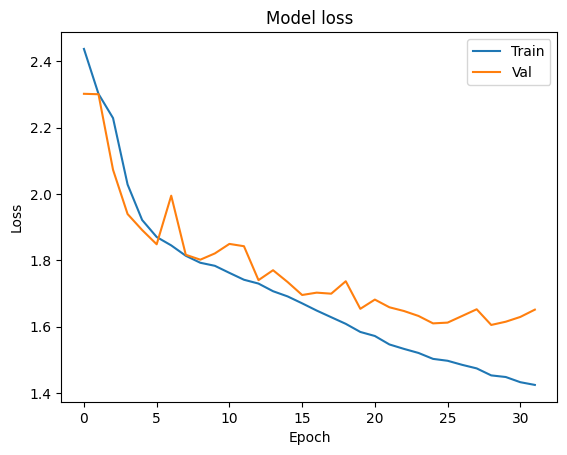

Epoch for best model: 28
Test accuracy for best model: 0.4174000024795532
Test precision for best model: 0.6049138903617859
Test recall for best model: 0.2142000049352646
Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_404 (Conv2D)         (None, 23, 23, 6)         1806      
                                                                 
 max_pooling2d_333 (MaxPooli  (None, 11, 11, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_339 (Dropout)       (None, 11, 11, 6)         0         
                                                                 
 conv2d_405 (Conv2D)         (None, 2, 2, 16)          9616      
                                                                 
 max_pooling2d_334 (MaxPooli  (None, 1, 1, 16)         0         
 ng2D)       

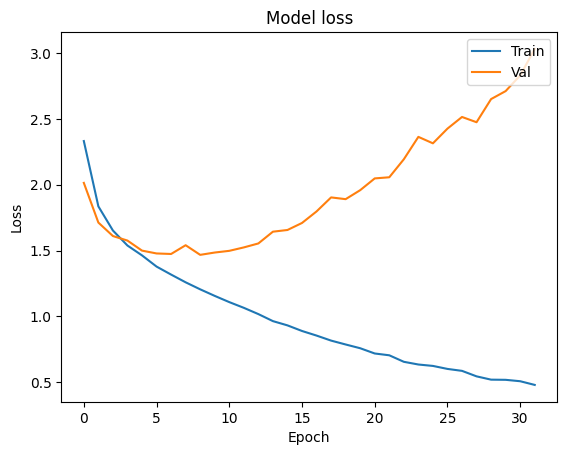

Epoch for best model: 8
Test accuracy for best model: 0.5012000203132629
Test precision for best model: 0.6411972641944885
Test recall for best model: 0.3449000120162964
Model: "sequential_189"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_406 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_335 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_341 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_407 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_336 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)        

In [ ]:
F = TestBench(kernel_scale=2)
F.evaluate()
A = TestBench(kernel_scale=1)
A.evaluate()




Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_358 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_308 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_312 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_359 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_309 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)                                                           
                                                                 
 dropout_313 (Dropout)       (None, 5, 5, 16)       

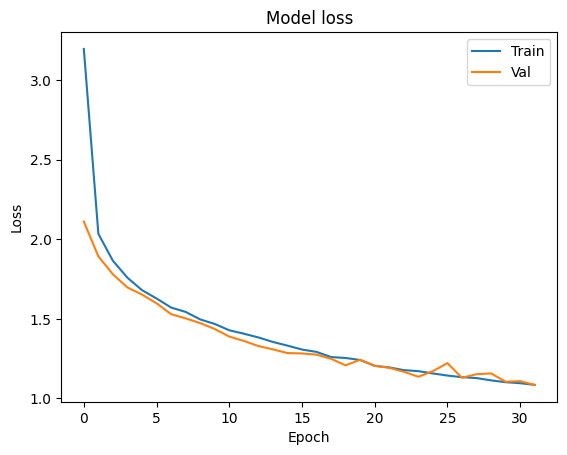

Epoch for best model: 31
Test accuracy for best model: 0.6144000291824341
Test precision for best model: 0.7705620527267456
Test recall for best model: 0.4496999979019165
Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_358 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_308 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_312 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_359 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_309 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)       

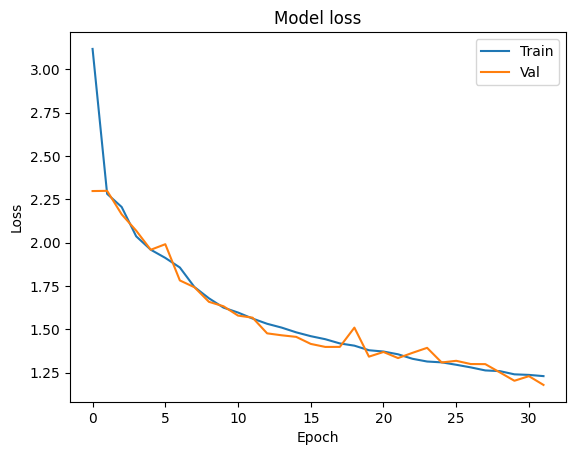

Epoch for best model: 31
Test accuracy for best model: 0.5848000049591064
Test precision for best model: 0.7818450927734375
Test recall for best model: 0.3695000112056732
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_360 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_310 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_314 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_361 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_311 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)       

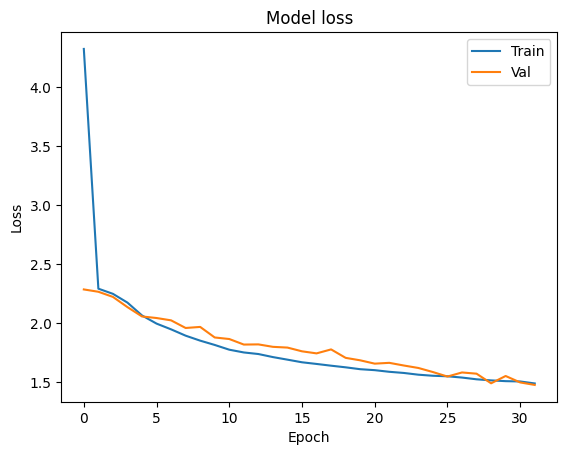

Epoch for best model: 31
Test accuracy for best model: 0.4839000105857849
Test precision for best model: 0.8050803542137146
Test recall for best model: 0.15530000627040863
Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_362 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_312 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_316 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_363 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_313 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)      

In [ ]:
H = TestBench(dropout=0.2)
H.evaluate()
I = TestBench(dropout=0.3)
I.evaluate()
J = TestBench(dropout=0.5)
J.evaluate()

Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_364 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_314 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_318 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_365 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_315 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)                                                           
                                                                 
 dropout_319 (Dropout)       (None, 5, 5, 16)       

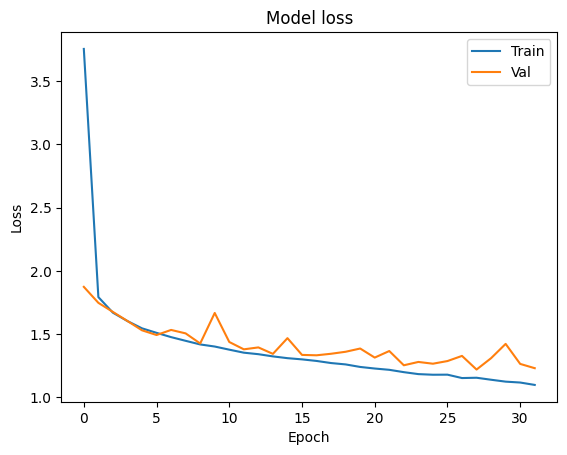

Epoch for best model: 27
Test accuracy for best model: 0.5827999711036682
Test precision for best model: 0.7230899930000305
Test recall for best model: 0.42590001225471497
Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_364 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_314 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_318 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_365 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_315 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)      

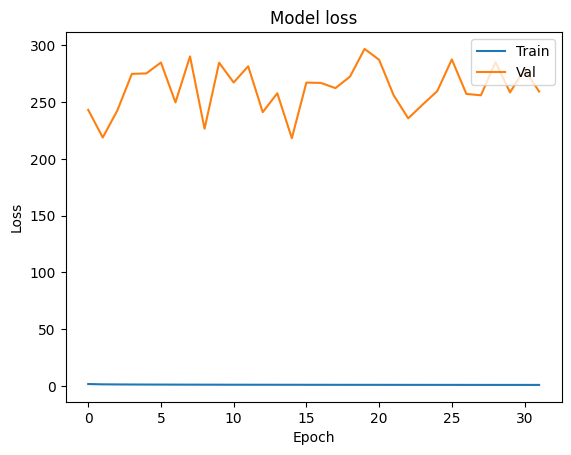

Epoch for best model: 14
Test accuracy for best model: 0.4684999883174896
Test precision for best model: 0.4684999883174896
Test recall for best model: 0.4684999883174896
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_366 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_316 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_320 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_367 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_317 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)       

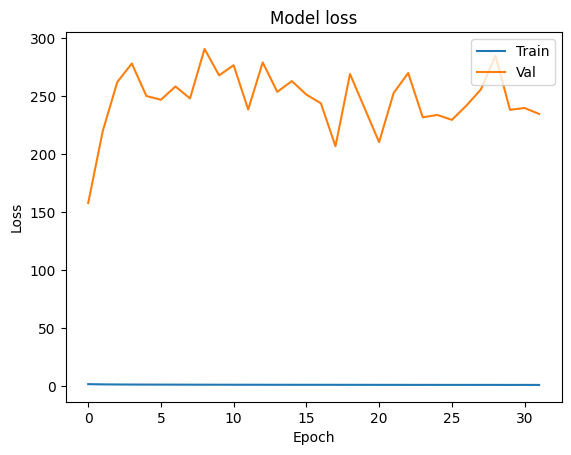

Epoch for best model: 0
Test accuracy for best model: 0.35920000076293945
Test precision for best model: 0.35920000076293945
Test recall for best model: 0.35920000076293945
Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_368 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_318 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_322 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_369 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_319 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)     

In [ ]:
tb1 = TestBench(augmentation=train_datagen_low, dropout=0)
tb1.evaluate()
tb2 = TestBench(augmentation=train_datagen_medium, dropout=0)
tb2.evaluate()
tb3 = TestBench(augmentation=train_datagen_high, dropout=0)
tb3.evaluate()

## Average Pooling Structure

In [ ]:
class PoolingTB(TestBench):
    def __init__(self, batch_size=128, epochs=32):
        # Split the training data into training and validation sets
        # Load CIFAR-10 dataset splits
        (x_train, y_train), (self.x_test, self.y_test) = load_data()

        # Convert class vectors to one-hot encoding
        y_train = to_categorical(y_train, 10)
        self.y_test = to_categorical(self.y_test, 10)

        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2) 
        
        model = models.Sequential()
        model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), input_shape=(32, 32, 3)))
        model.add(layers.Activation('relu'))
        model.add(layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(filters=16, kernel_size=(5, 5)))
        model.add(layers.Activation('relu'))
        model.add(layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=120, activation='relu'))
        model.add(layers.Dense(units=84, activation='relu'))
        model.add(layers.Dense(units=10, activation='softmax'))

        # Compile the model with categorical cross-entropy loss and Adam optimizer
        model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy", Precision(), Recall()],
        )

        model.build()
        model.summary()

        # Define a callback to save the best model based on validation loss
        best_epoch_callback = BestEpochCallback()
        checkpoint_callback = ModelCheckpoint(
            "best_model.h5",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            save_weights_only=False,
            verbose=1,
            save_freq="epoch",
            save_best_at_end=True,
        )
        callbacks = [checkpoint_callback, best_epoch_callback]

        self.history = model.fit(
            x_train, y_train, 
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data = (x_val, y_val)
        )
        
        # Store the best epoch
        self.best_epoch = best_epoch_callback.best_epoch


Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_396 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 activation_95 (Activation)  (None, 28, 28, 6)         0         
                                                                 
 average_pooling2d_37 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_397 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 activation_96 (Activation)  (None, 10, 10, 16)        0         
                                                                 
 average_pooling2d_38 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                       

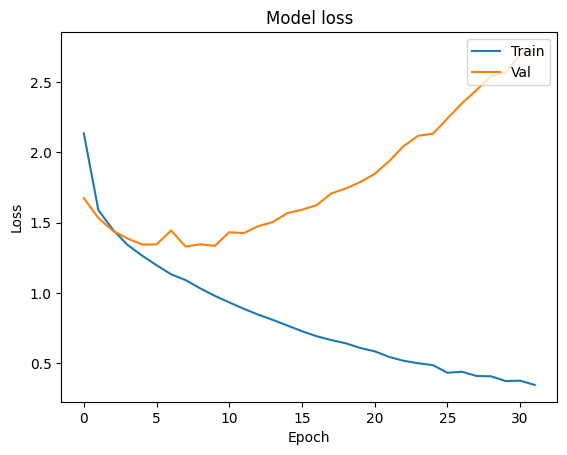

Epoch for best model: 7
Test accuracy for best model: 0.5309000015258789
Test precision for best model: 0.6703558564186096
Test recall for best model: 0.3937000036239624
Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_396 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 activation_95 (Activation)  (None, 28, 28, 6)         0         
                                                                 
 average_pooling2d_37 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_397 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 activation_96 (Activation)  (None, 10, 10, 16)        0         
              

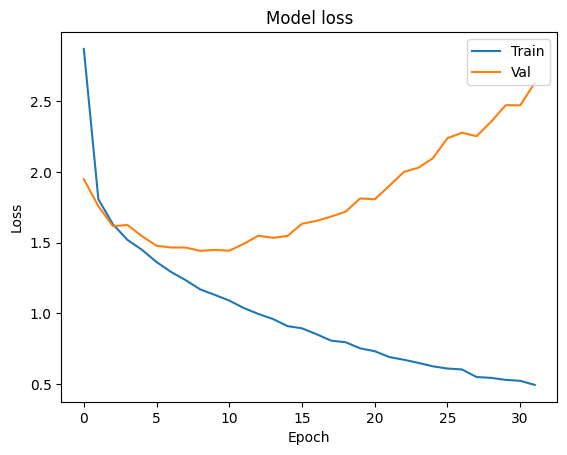

Epoch for best model: 8
Test accuracy for best model: 0.5063999891281128
Test precision for best model: 0.6599293351173401
Test recall for best model: 0.33629998564720154
Model: "sequential_185"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_398 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_328 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_334 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_399 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_329 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)       

In [ ]:
J = PoolingTB()
J.evaluate()
A = TestBench()
A.evaluate()

# Batch Normailisation

In [ ]:
class BatchNormTB(TestBench):
    def __init__(self, batch_size=128, epochs=32):
        # Split the training data into training and validation sets
        # Load CIFAR-10 dataset splits
        (x_train, y_train), (self.x_test, self.y_test) = load_data()

        # Convert class vectors to one-hot encoding
        y_train = to_categorical(y_train, 10)
        self.y_test = to_categorical(self.y_test, 10)

        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2) 
        
        model = models.Sequential()
        model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), input_shape=(32, 32, 3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(filters=16, kernel_size=(5, 5)))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=120, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(units=84, activation='relu'))
        model.add(layers.Dense(units=10, activation='softmax'))

        # Compile the model with categorical cross-entropy loss and Adam optimizer
        model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy", Precision(), Recall()],
        )

        model.build()
        model.summary()

        # Define a callback to save the best model based on validation loss
        best_epoch_callback = BestEpochCallback()
        checkpoint_callback = ModelCheckpoint(
            "best_model.h5",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            save_weights_only=False,
            verbose=1,
            save_freq="epoch",
            save_best_at_end=True,
        )
        callbacks = [checkpoint_callback, best_epoch_callback]

        self.history = model.fit(
            x_train, y_train, 
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data = (x_val, y_val)
        )
        
        # Store the best epoch
        self.best_epoch = best_epoch_callback.best_epoch


Model: "sequential_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_410 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 batch_normalization_76 (Bat  (None, 28, 28, 6)        24        
 chNormalization)                                                
                                                                 
 activation_97 (Activation)  (None, 28, 28, 6)         0         
                                                                 
 average_pooling2d_39 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_411 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_77 (Bat  (None, 10, 10, 16)    

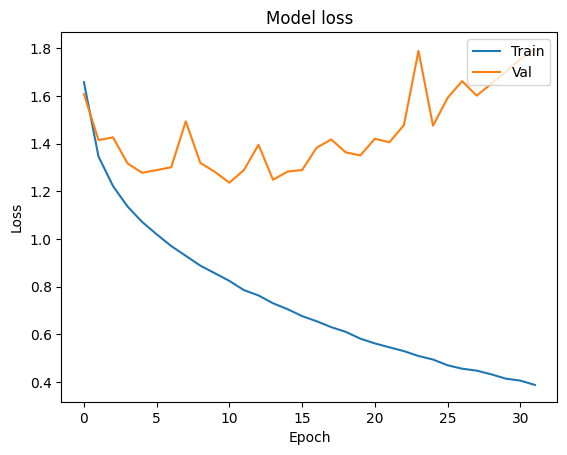

Epoch for best model: 10
Test accuracy for best model: 0.5985999703407288
Test precision for best model: 0.6892738342285156
Test recall for best model: 0.517300009727478
Model: "sequential_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_410 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 batch_normalization_76 (Bat  (None, 28, 28, 6)        24        
 chNormalization)                                                
                                                                 
 activation_97 (Activation)  (None, 28, 28, 6)         0         
                                                                 
 average_pooling2d_39 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_411 (C

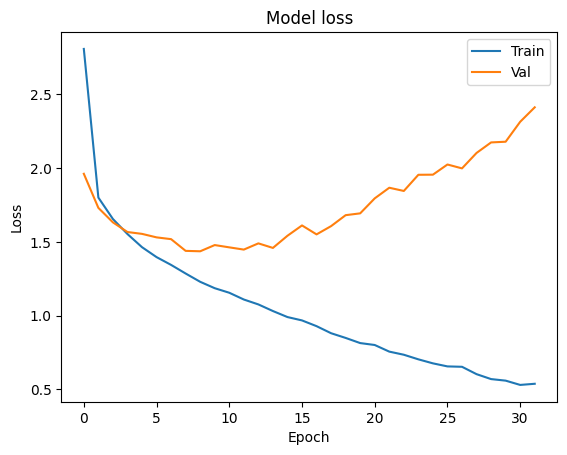

Epoch for best model: 8
Test accuracy for best model: 0.49779999256134033
Test precision for best model: 0.6545315384864807
Test recall for best model: 0.3416000008583069
Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_412 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_339 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_345 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_413 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_340 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)       

In [ ]:
L = BatchNormTB()
L.evaluate()
A= TestBench()
A.evaluate()

# Final Model

In [14]:
%pip install pydot
%pip install graphviz
from tensorflow.keras.utils import plot_model
class FinalModel(TestBench):
    def __init__(self, batch_size=128, epochs=32, augmentation=None):
        # Split the training data into training and validation sets
        # Load CIFAR-10 dataset splits
        (x_train, y_train), (self.x_test, self.y_test) = load_data()

        # Convert class vectors to one-hot encoding
        y_train = to_categorical(y_train, 10)
        self.y_test = to_categorical(self.y_test, 10)

        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
        
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(32, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        model.add(layers.Conv2D(64, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(64, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        model.add(layers.Conv2D(128, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(128, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        model.add(layers.Flatten())
        model.add(layers.Dense(512))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(10))
        model.add(layers.Activation('softmax'))

        # Compile the model with categorical cross-entropy loss and Adam optimizer
        model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy", Precision(), Recall()],
        )
        model.build()
        
        # Define a callback to save the best model based on validation loss
        best_epoch_callback = BestEpochCallback()
        checkpoint_callback = ModelCheckpoint(
            "best_model.h5",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            save_weights_only=False,
            verbose=1,
            save_freq="epoch",
            save_best_at_end=True,
        )
        callbacks = [checkpoint_callback, best_epoch_callback]

        if augmentation != None:
            # Split the training data into training and validation sets
            augmentation.fit(x_train)
            # Train the model for 10 epochs with a batch size of 32 and the checkpoint callback
            self.history = model.fit(
                augmentation.flow(x_train, y_train, batch_size=batch_size) if augmentation is not None else x_train,
                epochs=epochs,
                callbacks=callbacks,
                validation_data = (x_val, y_val)
            )
        else:
            # Squash pixel values between 0 and 1
            self.history = model.fit(
                x_train, y_train, 
                batch_size=batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data = (x_val, y_val)
            )
        
        # Store the best epoch
        self.best_epoch = best_epoch_callback.best_epoch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Epoch 1/60
312/313 [============================>.] - ETA: 0s - loss: 1.6317 - accuracy: 0.4342 - precision_8: 0.5756 - recall_8: 0.2705
Epoch 1: val_loss improved from inf to 1.47199, saving model to best_model.h5
313/313 [==============================] - 6s 16ms/step - loss: 1.6316 - accuracy: 0.4342 - precision_8: 0.5755 - recall_8: 0.2706 - val_loss: 1.4720 - val_accuracy: 0.4977 - val_precision_8: 0.6158 - val_recall_8: 0.3944
Epoch 2/60
310/313 [============================>.] - ETA: 0s - loss: 1.1444 - accuracy: 0.5935 - precision_8: 0.7211 - recall_8: 0.4649
Epoch 2: val_loss improved from 1.47199 to 1.12408, saving model to best_model.h5
313/313 [==============================] - 5s 14ms/step - loss: 1.1439 - accuracy: 0.5937 - precision_8: 0.7211 - recall_8: 0.4651 - val_loss: 1.1241 - val_accuracy: 0.6027 - val_precision_8: 0.7000 - val_recall_8: 0.5034
Epoch 3/60
310/313 [============================>.] - ETA: 0s - loss: 0.9224 - accuracy: 0.6745 - precision_8: 0.7799 - re

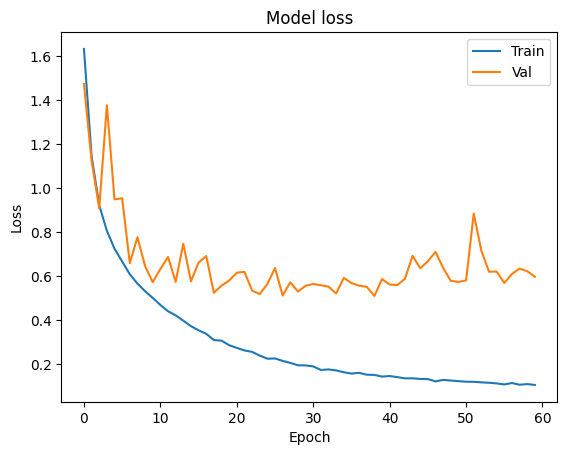

Epoch for best model: 38
Test accuracy for best model: 0.8525000214576721
Test precision for best model: 0.8669809103012085
Test recall for best model: 0.8460000157356262
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_56 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_64 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_57 (Bat  (None, 32, 32, 32)       128       
 chNormalizatio

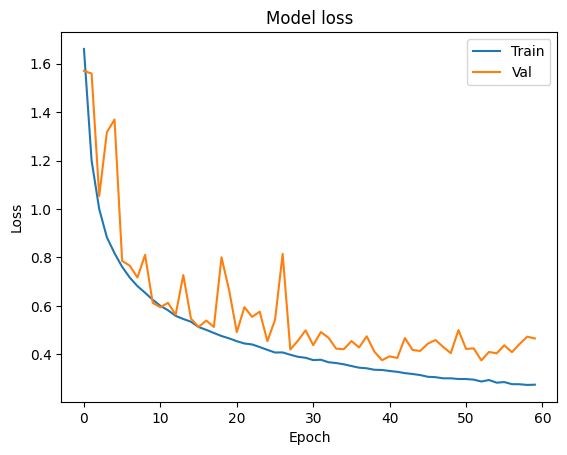

Epoch for best model: 52
Test accuracy for best model: 0.8690000176429749
Test precision for best model: 0.8893870115280151
Test recall for best model: 0.8531000018119812
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_63 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_72 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_64 (Bat  (None, 32, 32, 32)       128       
 chNormalizati

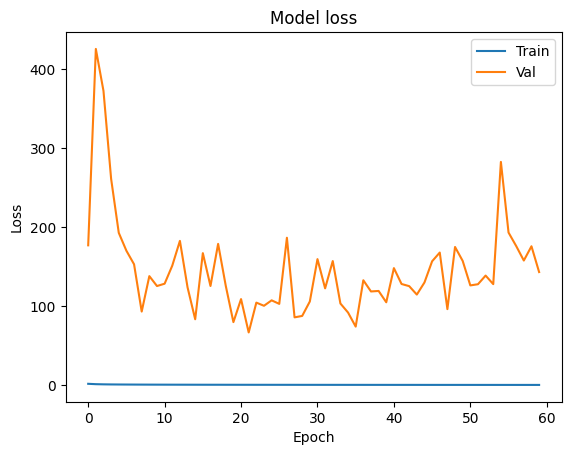

Epoch for best model: 21
Test accuracy for best model: 0.32429999113082886
Test precision for best model: 0.3246571123600006
Test recall for best model: 0.32429999113082886
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_70 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_80 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_71 (Bat  (None, 32, 32, 32)       128       
 chNormaliza

In [19]:
M = FinalModel(epochs=60, augmentation = None)
M.evaluate()
M = FinalModel(epochs=60, augmentation = train_datagen_low)
M.evaluate()
M = FinalModel(epochs=60, augmentation = train_datagen_medium)
M.evaluate()


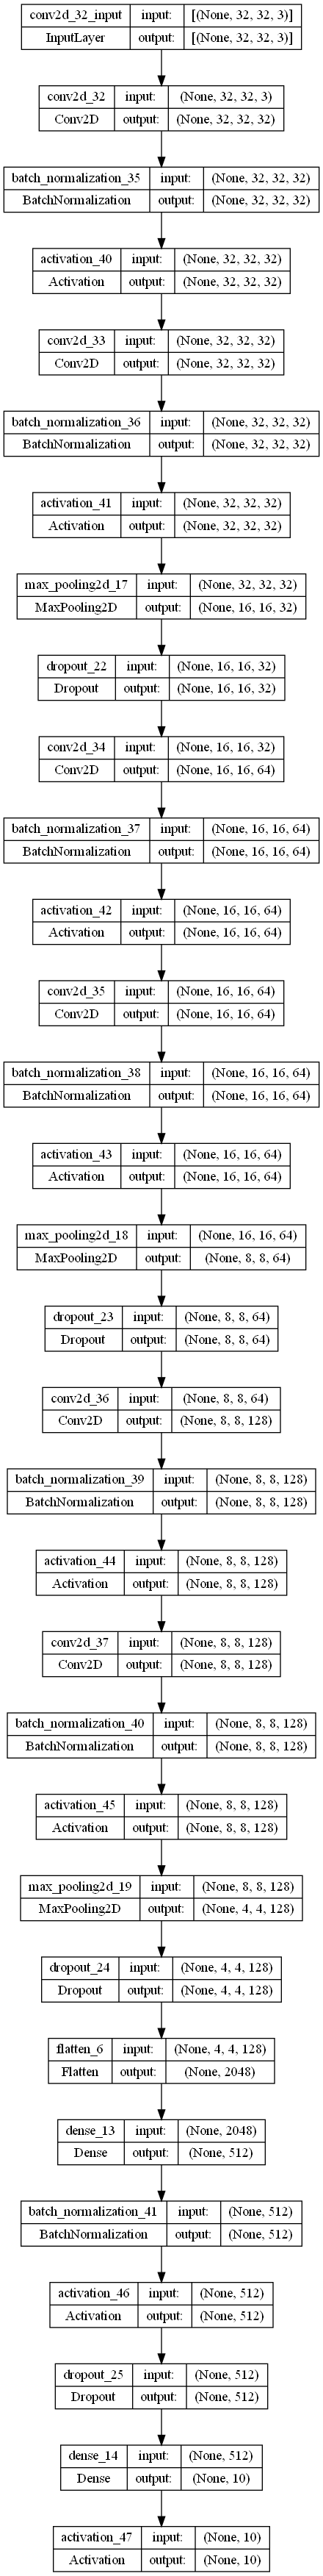

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10))
model.add(layers.Activation('softmax'))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Image(filename='model.png', width=600, height=300)

Model: "sequential_190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_408 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_337 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_343 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_409 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_338 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)                                                           
                                                                 
 dropout_344 (Dropout)       (None, 5, 5, 16)       

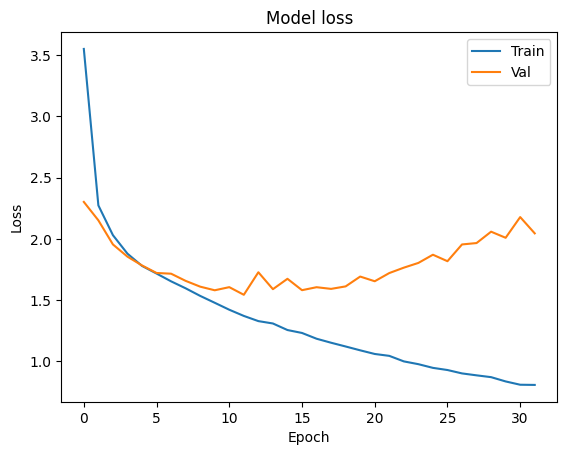

Epoch for best model: 11
Test accuracy for best model: 0.44269999861717224
Test precision for best model: 0.6234837174415588
Test recall for best model: 0.25699999928474426
Model: "sequential_190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_408 (Conv2D)         (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_337 (MaxPooli  (None, 14, 14, 6)        0         
 ng2D)                                                           
                                                                 
 dropout_343 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_409 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_338 (MaxPooli  (None, 5, 5, 16)         0         
 ng2D)     

AttributeError: 'TestBench' object has no attribute 'eavluate'

In [ ]:
A = TestBench()
A.evaluate()
A.eavluate()